https://www.youtube.com/watch?v=aircAruvnKk
https://www.youtube.com/watch?v=IHZwWFHWa-w

In [3]:
%matplotlib inline 
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

from IPython.display import Image, display
from matplotlib.pyplot import imshow

# Reload the module to pick up changes
import importlib
import module, support

importlib.reload(module)
importlib.reload(support)

from module import NumberRecognition, save_model_parameters
from support import load_mnist_data

In [4]:
# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Recognition Module

In [5]:
recognition_model = NumberRecognition().to(device)
recognition_model

NumberRecognition(
  (fc_head): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

# Load Data

In [6]:
# Load data from www.openml.org
mnist_path = r'D:/workspace/machine-learning/number-recognition/local_data/mnist.pickle'
X, y = load_mnist_data(mnist_path)

print(f"Dataset shapes: X={X.shape}, y={y.shape}")

Dataset shapes: X=(70000, 784), y=(70000,)


# Split the data (stratify preserves label proportions)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Ensure labels are integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_t = torch.tensor(y_train, dtype=torch.long, device=device)

X_test_t = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_t = torch.tensor(y_test, dtype=torch.long, device=device)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Now `train_dataset`, `test_dataset`, `train_loader`, and `test_loader` are available

## Explore the dataset

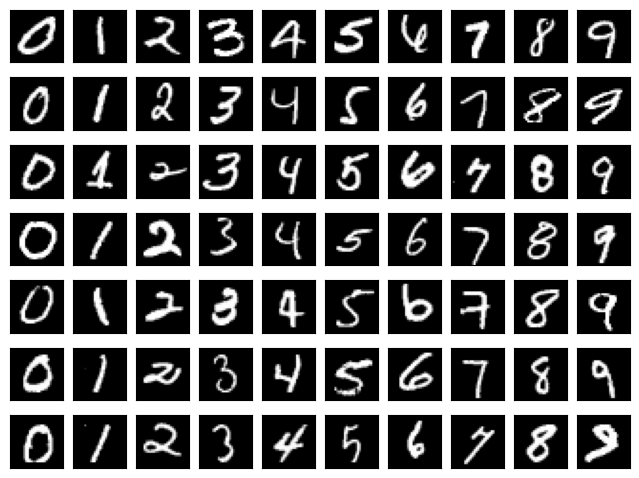

In [8]:
%matplotlib inline 
fig = plt.figure(figsize=(8,6))
for i in range(10):
    train_set_index = np.nonzero(y_train==i)[0]
    for j in range(7):
        ax = plt.subplot(7,10,i+j*10+1)        
        ax.imshow(np.reshape(X_train[train_set_index[j]],(28,28)),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
# demonstration purposes
x, y = next(iter(train_loader))
y_pred = recognition_model(x)
print(y_pred.argmax(dim=1))
print(x)

tensor([8, 2, 8, 7, 7, 6, 2, 3, 5, 8, 5, 5, 5, 3, 7, 8, 8, 1, 7, 6, 1, 8, 2, 1,
        6, 7, 6, 6, 8, 3, 1, 8, 7, 6, 3, 5, 7, 7, 5, 7, 2, 6, 6, 6, 1, 7, 1, 3,
        6, 8, 7, 8, 6, 8, 5, 1, 8, 7, 8, 8, 6, 1, 7, 6], device='cuda:0')
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


# train loop

In [10]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(recognition_model.parameters(), lr=0.001)

epoch_losses = []

for epoch in range(60):  # number of epochs
    recognition_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = recognition_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")
    if epoch % 10 == 9:
        # save model parameters every 10 epochs
        save_model_parameters(recognition_model, rf'D:\workspace\machine-learning\number-recognition\local_data\models\temp\model_epoch_{epoch+1}.pth')


Epoch 1, Loss: 0.3348
Epoch 2, Loss: 0.1489
Epoch 3, Loss: 0.1167
Epoch 4, Loss: 0.1051
Epoch 5, Loss: 0.0913
Epoch 6, Loss: 0.0845
Epoch 7, Loss: 0.0763
Epoch 8, Loss: 0.0719
Epoch 9, Loss: 0.0700
Epoch 10, Loss: 0.0638
Epoch 11, Loss: 0.0592
Epoch 12, Loss: 0.0611
Epoch 13, Loss: 0.0522
Epoch 14, Loss: 0.0502
Epoch 15, Loss: 0.0538
Epoch 16, Loss: 0.0424
Epoch 17, Loss: 0.0515
Epoch 18, Loss: 0.0451
Epoch 19, Loss: 0.0443
Epoch 20, Loss: 0.0424
Epoch 21, Loss: 0.0410
Epoch 22, Loss: 0.0452
Epoch 23, Loss: 0.0358
Epoch 24, Loss: 0.0365
Epoch 25, Loss: 0.0356
Epoch 26, Loss: 0.0431
Epoch 27, Loss: 0.0383
Epoch 28, Loss: 0.0302
Epoch 29, Loss: 0.0410
Epoch 30, Loss: 0.0415
Epoch 31, Loss: 0.0309
Epoch 32, Loss: 0.0311
Epoch 33, Loss: 0.0347
Epoch 34, Loss: 0.0418
Epoch 35, Loss: 0.0332
Epoch 36, Loss: 0.0365
Epoch 37, Loss: 0.0305
Epoch 38, Loss: 0.0302
Epoch 39, Loss: 0.0305
Epoch 40, Loss: 0.0398
Epoch 41, Loss: 0.0263
Epoch 42, Loss: 0.0318
Epoch 43, Loss: 0.0331
Epoch 44, Loss: 0.03

In [11]:
# Save the model's state dictionary
save_model_parameters(recognition_model, r'D:\workspace\machine-learning\number-recognition\local_data\models\number_recognition_model.pth')
print("Model saved successfully!")

Model saved successfully!


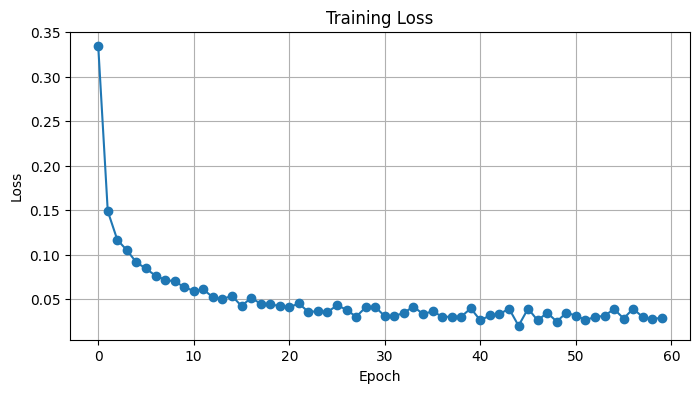

In [12]:
# Plot training loss
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

# Accuracy

In [13]:
# model accuracy evaluation
recognition_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = recognition_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 97.34%


In [14]:
# model accuracy evaluation
recognition_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = recognition_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = correct / total
print(f"Train Accuracy: {accuracy * 100:.2f}%")

Train Accuracy: 99.41%
